This notebook focuses on a dataset from the **Police Department of Rhode Island**. The rows are car stops that the police carry out and all the info related that they recorded. The aim is to perform data wrangling tasks with it and extract some intelligence that could help local law enforcement and regulators to understand better what is going on in the roads that they are watching out and securing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns
%matplotlib inline
from scipy import stats as ss

In [2]:
ri = pd.read_csv("../data/police.csv")

In [3]:
ri.head()

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [4]:
ri.shape

(91741, 15)

In [5]:
ri.dtypes

stop_date              object
stop_time              object
county_name           float64
driver_gender          object
driver_age_raw        float64
driver_age            float64
driver_race            object
violation_raw          object
violation              object
search_conducted         bool
search_type            object
stop_outcome           object
is_arrested            object
stop_duration          object
drugs_related_stop       bool
dtype: object

In [6]:
ri.isna().sum()

stop_date                 0
stop_time                 0
county_name           91741
driver_gender          5335
driver_age_raw         5327
driver_age             5621
driver_race            5333
violation_raw          5333
violation              5333
search_conducted          0
search_type           88545
stop_outcome           5333
is_arrested            5333
stop_duration          5333
drugs_related_stop        0
dtype: int64

### 1. Removing missing values. In particular the columns where all records are blank.

In [7]:
ri.dropna(axis=1, how="all", inplace=True)

In [8]:
ri.shape

(91741, 14)

#### Another way

In [9]:
ri = ri.dropna(thresh=ri.shape[0]*0.01, axis=1)

In [10]:
ri.head()

,stop_date,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,2005-01-02,01:55,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,2005-01-18,08:15,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,2005-01-23,23:15,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2005-02-20,17:15,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,2005-03-14,10:00,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [11]:
ri.shape

(91741, 14)

### 2. Do men or women speed more often?

In [12]:
ri.violation.value_counts()

Speeding               48463
Moving violation       16224
Equipment              11020
Other                   4317
Registration/plates     3432
Seat belt               2952
Name: violation, dtype: int64

In [13]:
ri[(ri.driver_gender=="M") & (ri.violation=="Speeding")].violation.count()

32979

In [14]:
ri[(ri.driver_gender=="F") & (ri.violation=="Speeding")].violation.count()

15482

#### A better more direct way (still filtering but in less code)

In [15]:
ri[ri.violation=="Speeding"]["driver_gender"].value_counts()

M    32979
F    15482
Name: driver_gender, dtype: int64

If I would like to have relative proportions instead of absolute values, as well as having it presented in a neat way, I would use the following:

In [16]:
ri_gender = ri[ri.violation=="Speeding"].driver_gender.value_counts(normalize=True).to_frame()

In [17]:
ri_gender["driver_gender"] = ri_gender["driver_gender"].apply(lambda x: x*100)

In [18]:
format_dict = {"driver_gender":"{:.2f}%", "violation":"{:.2f}%"}

In [19]:
ri_gender.style.format(format_dict)

,driver_gender
M,68.05%
F,31.95%


### 2b. Given that someone is pulled over, how often is because of speeding for men and how often is for women?

Men

In [20]:
ri_violation_M = ri[ri.driver_gender=="M"].violation.value_counts(normalize=True).to_frame()

In [21]:
ri_violation_M["violation"] = ri_violation_M["violation"].apply(lambda x: x*100)

In [22]:
(ri_violation_M.style.format(format_dict)
.apply(lambda x: ["background: tomato" if c == x.loc["Speeding"] else "" for c in x], axis=0)
)

,violation
Speeding,52.44%
Moving violation,20.70%
Equipment,13.57%
Other,5.77%
Registration/plates,3.85%
Seat belt,3.68%


Women

In [23]:
ri_violation_F = ri[ri.driver_gender=="F"].violation.value_counts(normalize=True).to_frame()

In [24]:
ri_violation_F["violation"] = ri_violation_F["violation"].apply(lambda x: x*100)

In [25]:
(ri_violation_F.style.format(format_dict)
.apply(lambda x: ["background: tomato" if c == x.loc["Speeding"] else "" for c in x], axis=0)
)

,violation
Speeding,65.85%
Moving violation,13.63%
Equipment,10.58%
Registration/plates,4.31%
Other,2.93%
Seat belt,2.70%


#### We can have it all in the same dataframe using groupby

In [26]:
ri.groupby("driver_gender").violation.value_counts(normalize=True).loc[:,"Speeding"].to_frame()

,violation
driver_gender,
F,0.65850
M,0.52435


In [27]:
ri_group = ri.groupby("driver_gender").violation.value_counts(normalize=True).unstack()

In [28]:
ri_group = ri_group.applymap(lambda x: x*100)

In [29]:
ri_group

violation,Equipment,Moving violation,Other,Registration/plates,Seat belt,Speeding
driver_gender,,,,,,
F,10.578027,13.627664,2.934796,4.308621,2.700863,65.850028
M,13.567056,20.701169,5.766754,3.846093,3.683918,52.435011


In [30]:
format_dict_2 = {"Equipment":"{:.2f}%", "Moving violation":"{:.2f}%", "Registration/plates":"{:.2f}%", 
                 "Seat belt":"{:.2f}%", "Speeding":"{:.2f}%", "Other":"{:.2f}%"}

In [31]:
(ri_group.style.format(format_dict_2)
.apply(lambda x: ["background: tomato" if c == x.loc["Speeding"] else "" for c in x], axis=1)
)

violation,Equipment,Moving violation,Other,Registration/plates,Seat belt,Speeding
driver_gender,,,,,,
F,10.58%,13.63%,2.93%,4.31%,2.70%,65.85%
M,13.57%,20.70%,5.77%,3.85%,3.68%,52.44%


### 3. Does gender affect who gets searched during a stop?

In [32]:
ri_crosstb = pd.crosstab(index=ri.driver_gender, columns=ri.search_conducted)

In [33]:
ri_crosstb

search_conducted,False,True
driver_gender,,
F,23040,471
M,60170,2725


In [34]:
ss.fisher_exact(ri_crosstb)

(2.215379143382497, 1.0608296038561537e-65)

It seems there is a significant effect of gender on being searched or not during a police stop.

In [35]:
ri_crosstb["proportions"] = ri_crosstb.apply(lambda x: (x.iloc[1] / x.iloc[0]), axis=1)

In [36]:
ri_crosstb

search_conducted,False,True,proportions
driver_gender,,,
F,23040,471,0.020443
M,60170,2725,0.045288


Another way to get the proportions (simpler if I dont want to perform a chi-square test)

In [37]:
ri.groupby("driver_gender").search_conducted.mean().to_frame()

,search_conducted
driver_gender,
F,0.020033
M,0.043326


Note. mean for boolean columns is like counting and dividing by 100 the times that the boolean takes one (whenever it is true)

In [38]:
ri_viol_gender = ri.groupby(["violation","driver_gender"]).search_conducted.mean().to_frame().unstack()
                

In [39]:
ri_viol_gender

search_conducted          
driver_gender                      F         M
violation                                     
Equipment                   0.042622  0.070081
Moving violation            0.036205  0.059831
Other                       0.056522  0.047146
Registration/plates         0.066140  0.110376
Seat belt                   0.012598  0.037980
Speeding                    0.008720  0.024925

#### Extra. Displaying both absolute and relative values in the same df

In [40]:
ri_search_con_abs = ri.search_conducted.value_counts().to_frame()

In [41]:
ri_search_con_rel = ri.search_conducted.value_counts(normalize=True).to_frame()

In [42]:
ri_search_comb = pd.concat([ri_search_con_abs, ri_search_con_rel], axis=1)

In [43]:
ri_search_comb

,search_conducted,search_conducted
False,88545,0.965163
True,3196,0.034837


### 4. Search conducted missing

In [44]:
ri.head(2)

,stop_date,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,2005-01-02,01:55,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,2005-01-18,08:15,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [45]:
ri.search_conducted.value_counts()

False    88545
True      3196
Name: search_conducted, dtype: int64

In [46]:
ri[ri.search_conducted == True]["search_type"].value_counts()

Incident to Arrest                                          1219
Probable Cause                                               891
Inventory                                                    220
Reasonable Suspicion                                         197
Protective Frisk                                             161
Incident to Arrest,Inventory                                 129
Incident to Arrest,Probable Cause                            106
Probable Cause,Reasonable Suspicion                           75
Incident to Arrest,Inventory,Probable Cause                   34
Incident to Arrest,Protective Frisk                           33
Probable Cause,Protective Frisk                               33
Inventory,Probable Cause                                      22
Incident to Arrest,Reasonable Suspicion                       13
Inventory,Protective Frisk                                    11
Incident to Arrest,Inventory,Protective Frisk                 11
Protective Frisk,Reasonab

In [47]:
ri[ri.search_conducted == False]["search_type"].value_counts(dropna=False)

NaN    88545
Name: search_type, dtype: int64

### 5. When a search is conducted in Rhode Island, how often is the driver frisked?

In [48]:
ri["frisked"] = ri.search_type.str.contains("Frisk")

In [49]:
ri.frisked.value_counts(dropna=False)

NaN      88545
False     2922
True       274
Name: frisked, dtype: int64

In [50]:
ri.frisked.value_counts(normalize=True).to_frame()

,frisked
False,0.914268
True,0.085732


It is not needed to filter the ri df to just let in the rows when a search was conducted, because then upon counting, the NaNs are ignored (dropped) by default

#### Another way in case I would like to have returned after the string check, a customized value instead of a true/false boolean

In [51]:
ri.search_conducted.value_counts()

False    88545
True      3196
Name: search_conducted, dtype: int64

In [52]:
ri_scT = ri[ri["search_conducted"] == True]

In [53]:
ri_scT.head()

,stop_date,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,frisked
24,2005-08-28,01:00,M,1979.0,26.0,White,Other Traffic Violation,Moving violation,True,"Incident to Arrest,Protective Frisk",Arrest Driver,True,16-30 Min,False,True
40,2005-10-01,00:00,M,1988.0,17.0,White,Equipment/Inspection Violation,Equipment,True,Probable Cause,Arrest Driver,True,16-30 Min,True,False
41,2005-10-01,00:00,M,1988.0,17.0,White,Equipment/Inspection Violation,Equipment,True,Probable Cause,Citation,False,30+ Min,True,False
80,2005-10-02,09:30,M,1975.0,30.0,White,Speeding,Speeding,True,Incident to Arrest,Arrest Driver,True,30+ Min,False,False
106,2005-10-03,14:00,M,1978.0,27.0,Black,Equipment/Inspection Violation,Equipment,True,Probable Cause,Citation,False,16-30 Min,False,False


In [54]:
t = ri_scT["search_type"].str.contains("Frisk")

In [55]:
ri_scT.loc[t, "frisked"] = ri_scT.loc[t, "frisked"].replace(True, "yes")

/home/salva/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [56]:
ri_scT["frisked"] = ri_scT["frisked"].replace(False, "no")

/home/salva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
ri_scT.head()

,stop_date,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,frisked
24,2005-08-28,01:00,M,1979.0,26.0,White,Other Traffic Violation,Moving violation,True,"Incident to Arrest,Protective Frisk",Arrest Driver,True,16-30 Min,False,yes
40,2005-10-01,00:00,M,1988.0,17.0,White,Equipment/Inspection Violation,Equipment,True,Probable Cause,Arrest Driver,True,16-30 Min,True,no
41,2005-10-01,00:00,M,1988.0,17.0,White,Equipment/Inspection Violation,Equipment,True,Probable Cause,Citation,False,30+ Min,True,no
80,2005-10-02,09:30,M,1975.0,30.0,White,Speeding,Speeding,True,Incident to Arrest,Arrest Driver,True,30+ Min,False,no
106,2005-10-03,14:00,M,1978.0,27.0,Black,Equipment/Inspection Violation,Equipment,True,Probable Cause,Citation,False,16-30 Min,False,no


In [58]:
ri_scT.frisked.value_counts(normalize=True).to_frame()

,frisked
no,0.914268
yes,0.085732


### 6. Which year had the least number of stops?

In [59]:
ri_dt = ri.copy()

#### With datetime format and lambdas

In [60]:
ri_dt["stop_date"] = pd.to_datetime(ri_dt["stop_date"])

In [61]:
ri_dt["year_stop"] = ri_dt.stop_date.apply(lambda x: x.year)

In [62]:
ri_dt.year_stop.value_counts().sort_values().index[0]

2005

#### With datetime format as well and no lambda

In [63]:
combined = ri.stop_date.str.cat(ri.stop_time, sep = " ")

In [64]:
ri_dt["stop_datetime"] = pd.to_datetime(combined)

In [65]:
ri_dt.stop_datetime.dt.year.value_counts().sort_values().to_frame()

,stop_datetime
2005,2558
2010,7561
2009,7908
2013,7924
2011,8126
2015,8599
2008,8752
2014,9228
2007,9476
2006,10639


It also works in the stop_date column straigth away. That is because it was also converted into datetime format

In [66]:
ri_dt.stop_date.dt.year.value_counts().sort_values().to_frame()

,stop_date
2005,2558
2010,7561
2009,7908
2013,7924
2011,8126
2015,8599
2008,8752
2014,9228
2007,9476
2006,10639


#### With strings

#### A straight-forward string method

In [67]:
ri.stop_date.str.slice(0,4).value_counts().sort_values().to_frame()

,stop_date
2005,2558
2010,7561
2009,7908
2013,7924
2011,8126
2015,8599
2008,8752
2014,9228
2007,9476
2006,10639


#### A less straight-forward way with strings as well

In [68]:
ri["year_stop"] = ri.stop_date.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").year)

In [69]:
ri.year_stop.value_counts().sort_values().to_frame()

,year_stop
2005,2558
2010,7561
2009,7908
2013,7924
2011,8126
2015,8599
2008,8752
2014,9228
2007,9476
2006,10639


### 7. How drug activity change by time of the day?

In [70]:
ri["stop_datetime"] = ri_dt["stop_datetime"]

In [71]:
ri.drugs_related_stop.value_counts()

False    90926
True       815
Name: drugs_related_stop, dtype: int64

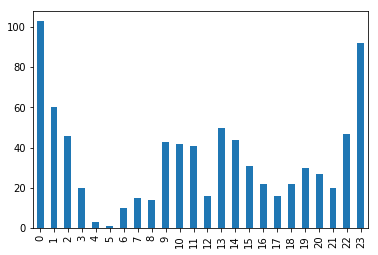

In [72]:
ri[(ri.drugs_related_stop == True)].stop_datetime.dt.hour.value_counts().sort_index().plot(kind="bar")

### 8. Do most stops occur at night?


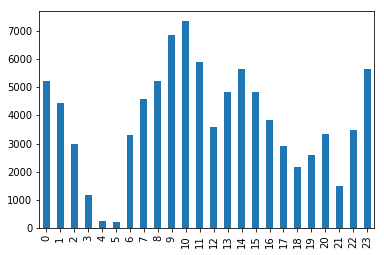

In [73]:
ri.stop_datetime.dt.hour.value_counts().sort_index().plot(kind="bar")

#### Another way. Using groupby

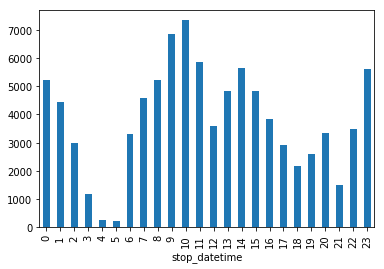

In [74]:
ri.groupby(ri.stop_datetime.dt.hour)["stop_date"].count().plot(kind="bar")